---
## 1. Thiết Lập & Tải Dữ Liệu

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Styling
sns.set_theme(style="white", palette="tab10")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10

# Color palette
colors = {
    'PySATSolver': '#2ecc71',
    'AStar_Basic': '#3498db',
    'AStar_Weighted': '#9b59b6',
    'AStar_MOMs': '#f14c92',
    'AStar_JW': '#e74c3c',
    'AStarSolver': '#1abc9c',
    'BacktrackingSolver': '#e67e22',
    'BruteForceSolver': "#C6D406"
}

print("✓ Libraries loaded")

✓ Libraries loaded


In [3]:
# Load data
df = pd.read_csv("data/outputs/benchmark_report.csv")

# Clean data
df["Time (s)"] = pd.to_numeric(df["Time (s)"], errors="coerce")
df["Memory (MB)"] = pd.to_numeric(df["Memory (MB)"], errors="coerce")
df["Correct"] = df["Correct"].astype(bool)
df["Timeout"] = df["Status"] == "TIMEOUT"

# Filter successful runs
df_success = df[~df["Timeout"]].copy()

# Identify solver types
all_solvers = df['Solver'].unique().tolist()
astar_variants = [s for s in all_solvers if 'AStar' in s or 'A*' in s]

print(f"✓ Loaded {len(df)} records | {df['Input'].nunique()} inputs | {len(all_solvers)} solvers")
print(f"\nSolvers: {all_solvers}")
print(f"A* Variants: {astar_variants}")
df.head()

✓ Loaded 33 records | 11 inputs | 3 solvers

Solvers: ['PySATSolver', 'AStar_Basic', 'AStar_Weighted']
A* Variants: ['AStar_Basic', 'AStar_Weighted']


,Input,Solver,Status,Time (s),Memory (MB),Correct,Pass 1min,Pass 2min,Pass 5min,Timeout
0,input-00.txt,PySATSolver,OK,0.0083,0.0429,True,True,True,True,False
1,input-00.txt,AStar_Basic,OK,36.2100,0.1171,True,True,True,True,False
2,input-00.txt,AStar_Weighted,OK,48.2646,0.1180,True,True,True,True,False
3,input-01.txt,PySATSolver,OK,0.0130,0.0606,True,True,True,True,False
4,input-01.txt,AStar_Basic,TIMEOUT,300.0000,0.0000,False,False,False,False,True


---
## 2. Thống Kê Tổng Quan

In [4]:
# Summary statistics
summary = df.groupby("Solver").agg({
    "Correct": ["sum", "mean"],
    "Timeout": "sum",
    "Time (s)": ["mean", "median"],
    "Memory (MB)": ["mean", "median"]
}).round(4)

summary.columns = ['Thành_Công', 'Tỷ_Lệ_%', 'Timeout', 'TB_Time', 'Median_Time', 'TB_Mem', 'Median_Mem']
summary['Tỷ_Lệ_%'] = (summary['Tỷ_Lệ_%'] * 100).round(1)
summary = summary.sort_values('Tỷ_Lệ_%', ascending=False)

print("="*70)
print("THỐNG KÊ TỔNG QUAN")
print("="*70)
summary

THỐNG KÊ TỔNG QUAN


,Thành_Công,Tỷ_Lệ_%,Timeout,TB_Time,Median_Time,TB_Mem,Median_Mem
Solver,,,,,,,
PySATSolver,11,100.0,0,0.1514,0.0266,0.3441,0.1794
AStar_Basic,1,9.1,10,276.0191,300.0000,0.0106,0.0000
AStar_Weighted,1,9.1,10,277.1150,300.0000,0.0107,0.0000


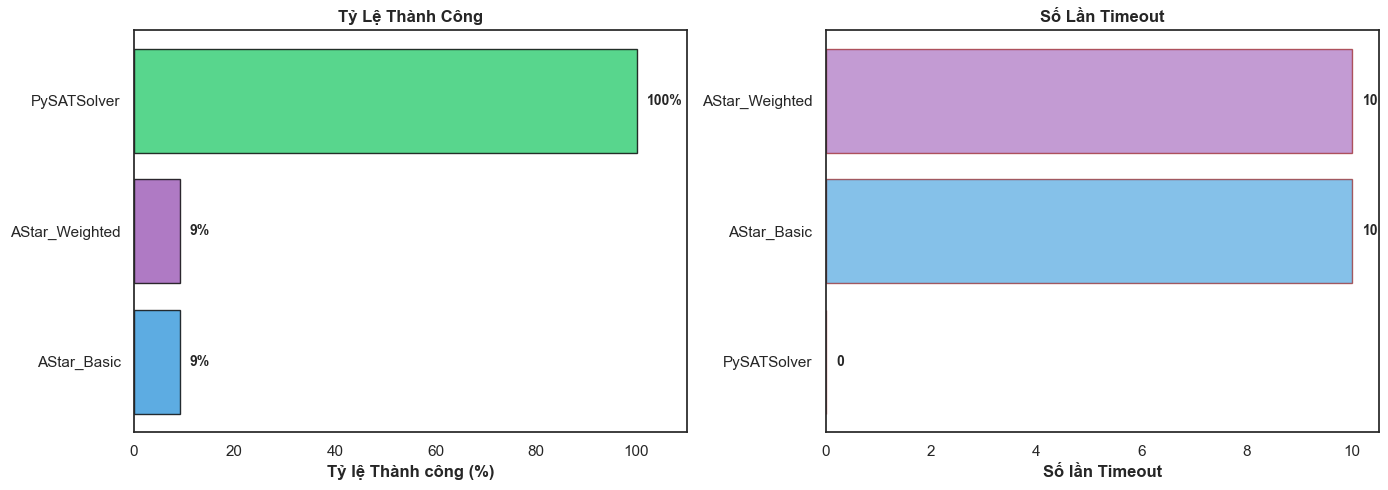

In [5]:
# Tỷ lệ thành công & Timeout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Success Rate
ax1 = axes[0]
data = summary.sort_values('Tỷ_Lệ_%')
bars = ax1.barh(data.index, data['Tỷ_Lệ_%'], 
                color=[colors.get(s, '#95a5a6') for s in data.index],
                alpha=0.8, edgecolor='black')
ax1.set_xlabel('Tỷ lệ Thành công (%)', fontweight='bold')
ax1.set_title('Tỷ Lệ Thành Công', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 110)
for i, v in enumerate(data['Tỷ_Lệ_%']):
    ax1.text(v + 2, i, f'{v:.0f}%', va='center', fontweight='bold')

# Timeout
ax2 = axes[1]
data2 = summary.sort_values('Timeout')
bars2 = ax2.barh(data2.index, data2['Timeout'],
                 color=[colors.get(s, '#95a5a6') for s in data2.index],
                 alpha=0.6, edgecolor='darkred')
ax2.set_xlabel('Số lần Timeout', fontweight='bold')
ax2.set_title('Số Lần Timeout', fontsize=12, fontweight='bold')
for i, v in enumerate(data2['Timeout']):
    ax2.text(v + 0.2, i, f'{int(v)}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 3. So Sánh Thời Gian

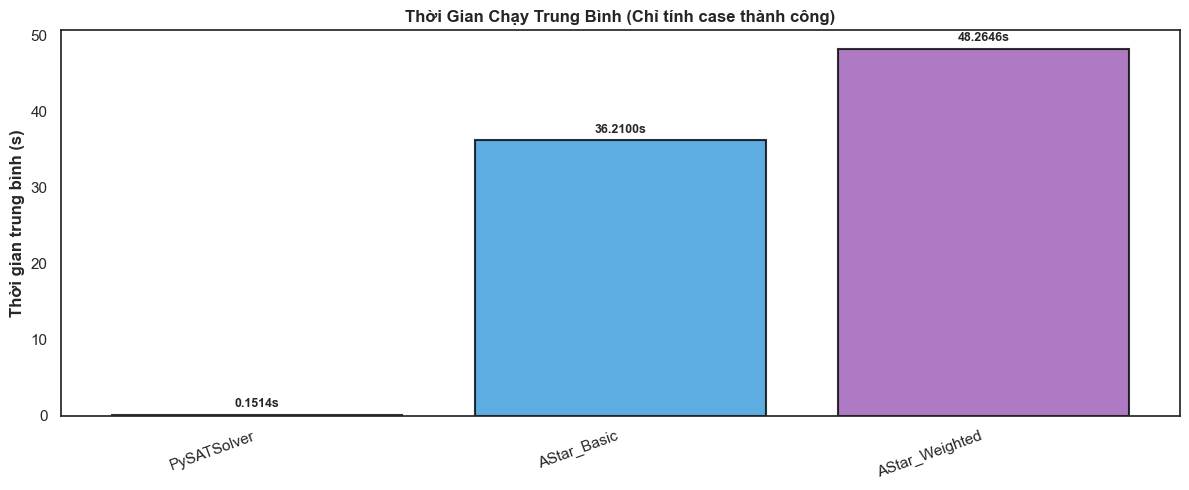

In [6]:
# Thời gian trung bình
avg_time = df_success.groupby("Solver")["Time (s)"].mean().sort_values()

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(avg_time)), avg_time.values,
               color=[colors.get(s, '#95a5a6') for s in avg_time.index],
               alpha=0.8, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(avg_time)), avg_time.index, rotation=20, ha='right')
plt.ylabel('Thời gian trung bình (s)', fontweight='bold')
plt.title('Thời Gian Chạy Trung Bình (Chỉ tính case thành công)', fontsize=12, fontweight='bold')

for i, v in enumerate(avg_time.values):
    plt.text(i, v + max(avg_time)*0.02, f'{v:.4f}s', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

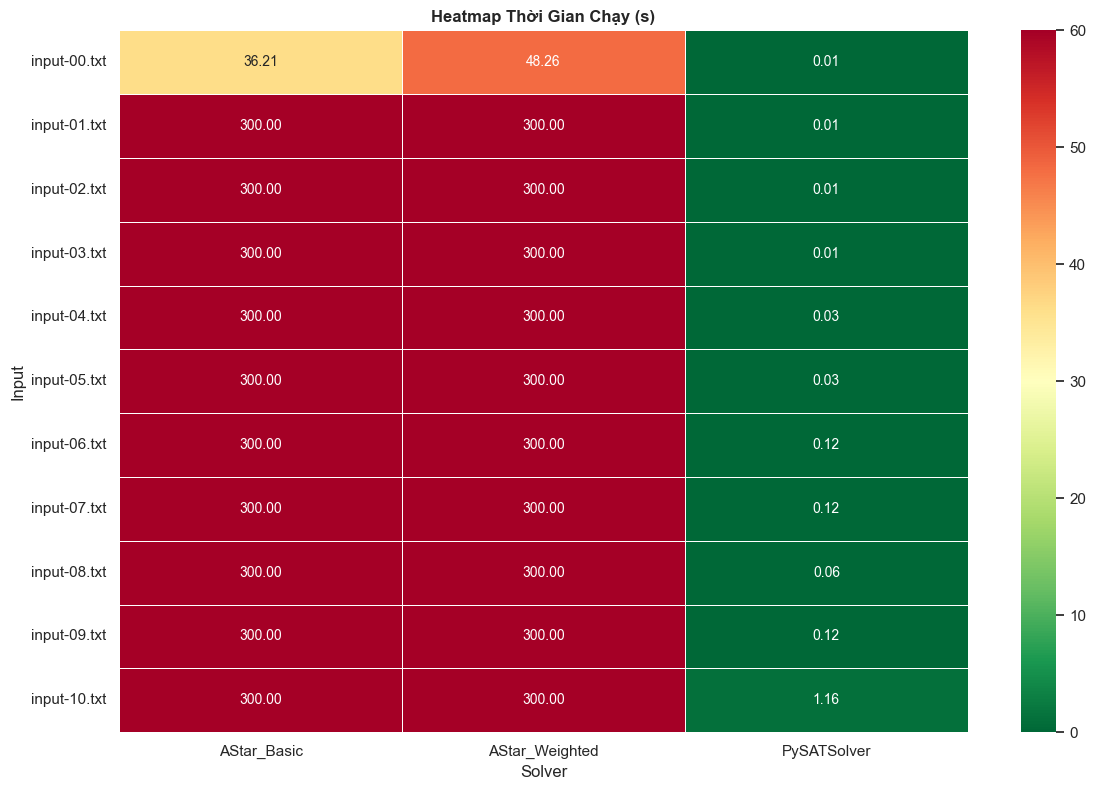

In [7]:
# Heatmap thời gian
pivot_time = df.pivot(index="Input", columns="Solver", values="Time (s)")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_time, annot=True, fmt='.2f', cmap='RdYlGn_r',
            linewidths=0.5, vmin=0, vmax=min(pivot_time.max().max(), 60))
plt.title('Heatmap Thời Gian Chạy (s)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. So Sánh Bộ Nhớ

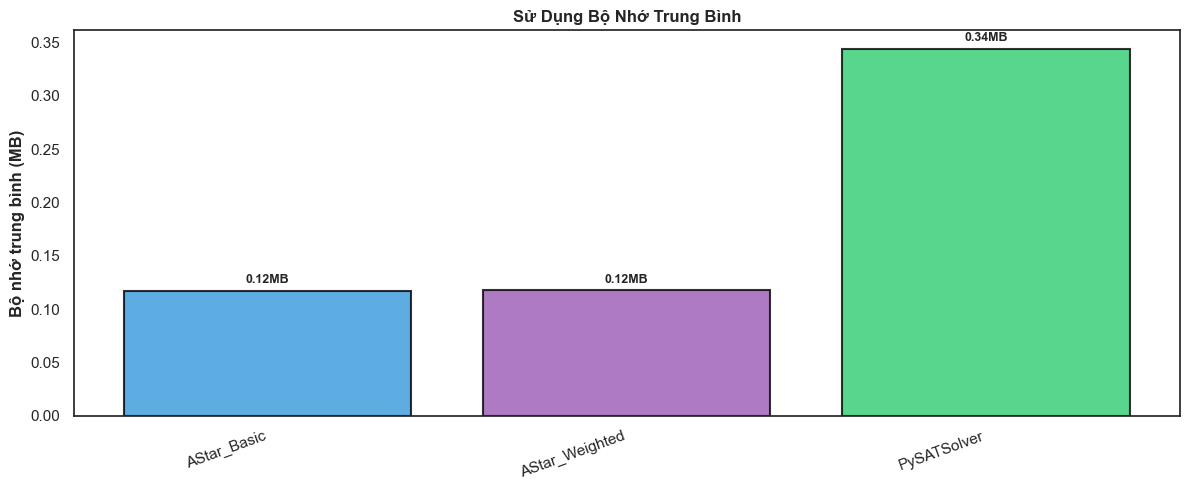

In [8]:
# Bộ nhớ trung bình
avg_mem = df_success.groupby("Solver")["Memory (MB)"].mean().sort_values()

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(avg_mem)), avg_mem.values,
               color=[colors.get(s, '#95a5a6') for s in avg_mem.index],
               alpha=0.8, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(avg_mem)), avg_mem.index, rotation=20, ha='right')
plt.ylabel('Bộ nhớ trung bình (MB)', fontweight='bold')
plt.title('Sử Dụng Bộ Nhớ Trung Bình', fontsize=12, fontweight='bold')

for i, v in enumerate(avg_mem.values):
    plt.text(i, v + max(avg_mem)*0.02, f'{v:.2f}MB', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

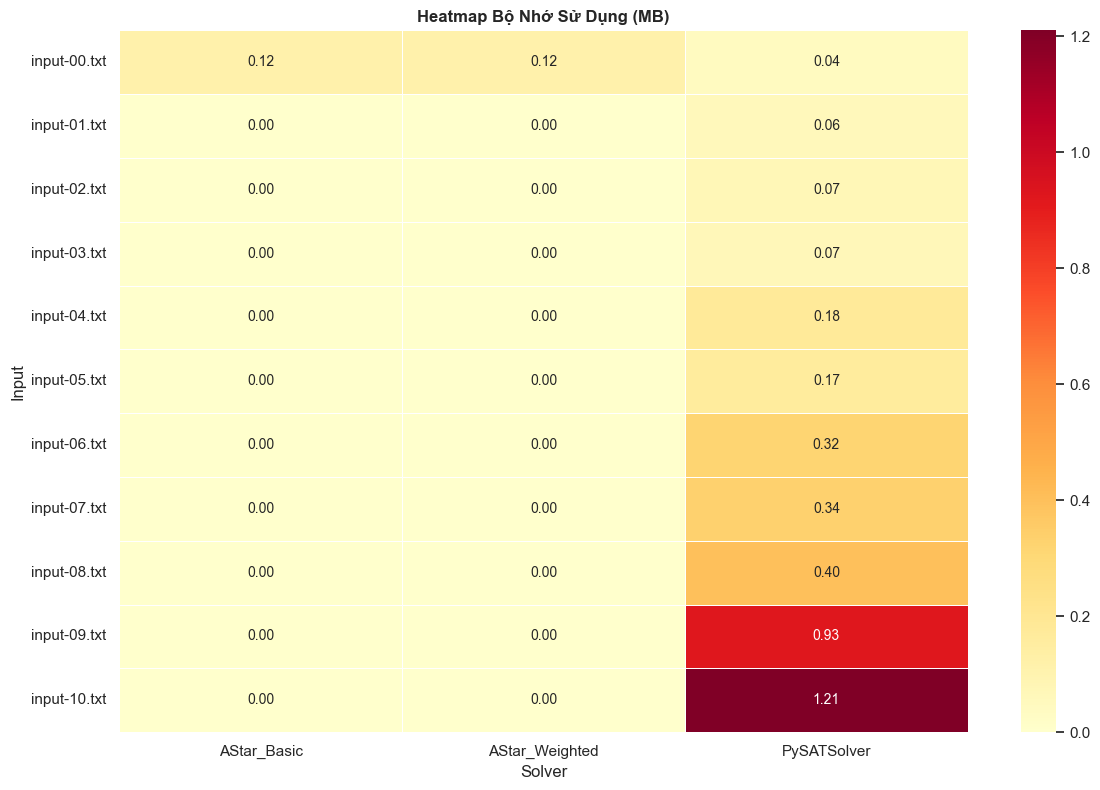

In [9]:
# Heatmap bộ nhớ
pivot_mem = df.pivot(index="Input", columns="Solver", values="Memory (MB)")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_mem, annot=True, fmt='.2f', cmap='YlOrRd',
            linewidths=0.5)
plt.title('Heatmap Bộ Nhớ Sử Dụng (MB)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. So Sánh Các Phiên Bản A*

In [10]:
# So sánh A* variants với PySAT
print("="*70)
print("SO SÁNH CÁC PHIÊN BẢN A* VỚI PYSAT")
print("="*70)

if len(astar_variants) == 0:
    print("⚠ Không tìm thấy A* variants trong dữ liệu")
else:
    # Filter data
    compare_solvers = ['PySATSolver'] + astar_variants
    compare_df = df[df['Solver'].isin(compare_solvers)].copy()
    
    # Stats
    astar_stats = compare_df.groupby('Solver').agg({
        'Correct': ['sum', 'mean'],
        'Timeout': 'sum',
        'Time (s)': 'mean',
        'Memory (MB)': 'mean'
    }).round(4)
    astar_stats.columns = ['Thành_Công', 'Tỷ_Lệ', 'Timeout', 'TB_Time', 'TB_Mem']
    astar_stats['Tỷ_Lệ'] = (astar_stats['Tỷ_Lệ'] * 100).round(1)
    print(astar_stats)
    print()

SO SÁNH CÁC PHIÊN BẢN A* VỚI PYSAT
                Thành_Công  Tỷ_Lệ  Timeout   TB_Time  TB_Mem
Solver                                                      
AStar_Basic              1    9.1       10  276.0191  0.0106
AStar_Weighted           1    9.1       10  277.1150  0.0107
PySATSolver             11  100.0        0    0.1514  0.3441



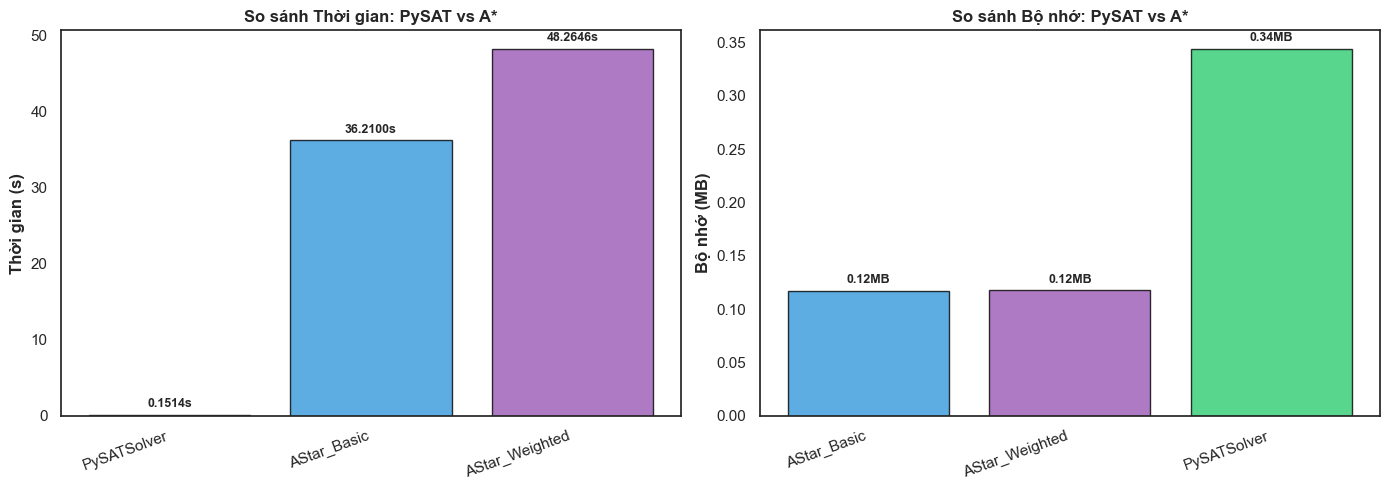

In [11]:
# Biểu đồ so sánh A* variants
if len(astar_variants) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    compare_success = compare_df[~compare_df['Timeout']]
    
    # Time
    ax1 = axes[0]
    t_data = compare_success.groupby('Solver')['Time (s)'].mean().sort_values()
    bars1 = ax1.bar(range(len(t_data)), t_data.values,
                    color=[colors.get(s, '#95a5a6') for s in t_data.index],
                    alpha=0.8, edgecolor='black')
    ax1.set_xticks(range(len(t_data)))
    ax1.set_xticklabels(t_data.index, rotation=20, ha='right')
    ax1.set_ylabel('Thời gian (s)', fontweight='bold')
    ax1.set_title('So sánh Thời gian: PySAT vs A*', fontweight='bold')
    for i, v in enumerate(t_data.values):
        ax1.text(i, v + max(t_data)*0.02, f'{v:.4f}s', ha='center', fontsize=9, fontweight='bold')
    
    # Memory
    ax2 = axes[1]
    m_data = compare_success.groupby('Solver')['Memory (MB)'].mean().sort_values()
    bars2 = ax2.bar(range(len(m_data)), m_data.values,
                    color=[colors.get(s, '#95a5a6') for s in m_data.index],
                    alpha=0.8, edgecolor='black')
    ax2.set_xticks(range(len(m_data)))
    ax2.set_xticklabels(m_data.index, rotation=20, ha='right')
    ax2.set_ylabel('Bộ nhớ (MB)', fontweight='bold')
    ax2.set_title('So sánh Bộ nhớ: PySAT vs A*', fontweight='bold')
    for i, v in enumerate(m_data.values):
        ax2.text(i, v + max(m_data)*0.02, f'{v:.2f}MB', ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [12]:
# Xác định A* variant tốt nhất
print("="*70)
print("XẾP HẠNG A* VARIANTS")
print("="*70)

best_astar = None

if len(astar_variants) > 0:
    astar_df = df[df['Solver'].isin(astar_variants)].copy()
    
    ranking = pd.DataFrame()
    for solver in astar_variants:
        s_data = astar_df[astar_df['Solver'] == solver]
        s_success = s_data[~s_data['Timeout']]
        
        ranking.loc[solver, 'Success_Rate'] = s_data['Correct'].mean()
        ranking.loc[solver, 'Avg_Time'] = s_success['Time (s)'].mean() if len(s_success) > 0 else 300
        ranking.loc[solver, 'Avg_Memory'] = s_success['Memory (MB)'].mean() if len(s_success) > 0 else 0
        ranking.loc[solver, 'Timeout_Rate'] = s_data['Timeout'].mean()
    
    # Score (higher = better)
    ranking['Score'] = (
        ranking['Success_Rate'] * 40 +
        (1 - ranking['Avg_Time']/300) * 30 +
        (1 - ranking['Timeout_Rate']) * 20 +
        10  # base
    )
    ranking = ranking.sort_values('Score', ascending=False)
    
    print(ranking[['Success_Rate', 'Avg_Time', 'Avg_Memory', 'Score']].round(2))
    
    best_astar = ranking.index[0]
    print(f"\n🏆 A* TỐT NHẤT: {best_astar}")
else:
    print("⚠ Không có A* variants để xếp hạng")

XẾP HẠNG A* VARIANTS
                Success_Rate  Avg_Time  Avg_Memory  Score
AStar_Basic             0.09     36.21        0.12  41.83
AStar_Weighted          0.09     48.26        0.12  40.63

🏆 A* TỐT NHẤT: AStar_Basic


---
## 6. So Sánh A* Tốt Nhất vs Các Solver Khác

In [13]:
# So sánh Best A* với PySAT, Backtracking, BruteForce
print("="*70)
print("SO SÁNH TỔNG HỢP")
print("="*70)

final_solvers = ['PySATSolver']
if best_astar:
    final_solvers.append(best_astar)
if 'BacktrackingSolver' in all_solvers:
    final_solvers.append('BacktrackingSolver')
if 'BruteForceSolver' in all_solvers:
    final_solvers.append('BruteForceSolver')

print(f"So sánh: {final_solvers}\n")

final_df = df[df['Solver'].isin(final_solvers)].copy()

for solver in final_solvers:
    s_data = final_df[final_df['Solver'] == solver]
    s_success = s_data[~s_data['Timeout']]
    
    print(f"📊 {solver}:")
    print(f"   ✓ Thành công: {int(s_data['Correct'].sum())}/{len(s_data)} ({s_data['Correct'].mean()*100:.0f}%)")
    if len(s_success) > 0:
        print(f"   ⏱ Thời gian TB: {s_success['Time (s)'].mean():.4f}s")
        print(f"   💾 Bộ nhớ TB: {s_success['Memory (MB)'].mean():.2f}MB")
    print(f"   ⏰ Timeout: {int(s_data['Timeout'].sum())}")
    print()

SO SÁNH TỔNG HỢP
So sánh: ['PySATSolver', 'AStar_Basic']

📊 PySATSolver:
   ✓ Thành công: 11/11 (100%)
   ⏱ Thời gian TB: 0.1514s
   💾 Bộ nhớ TB: 0.34MB
   ⏰ Timeout: 0

📊 AStar_Basic:
   ✓ Thành công: 1/11 (9%)
   ⏱ Thời gian TB: 36.2100s
   💾 Bộ nhớ TB: 0.12MB
   ⏰ Timeout: 10



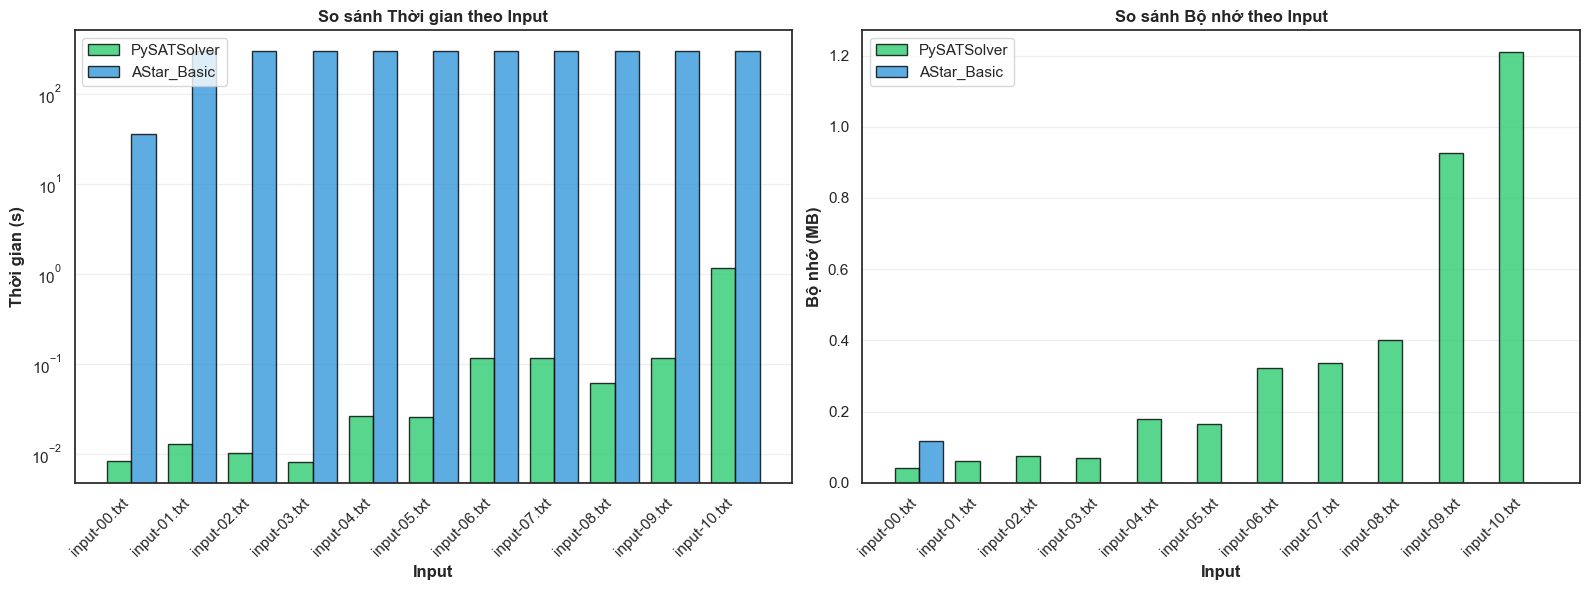

In [14]:
# Biểu đồ so sánh chi tiết theo Input
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

inputs = sorted(final_df['Input'].unique())
x = np.arange(len(inputs))
width = 0.8 / len(final_solvers)

# Time comparison
ax1 = axes[0]
for i, solver in enumerate(final_solvers):
    times = []
    for inp in inputs:
        val = final_df[(final_df['Input']==inp) & (final_df['Solver']==solver)]['Time (s)'].values
        times.append(val[0] if len(val) > 0 else 300)
    offset = (i - len(final_solvers)/2 + 0.5) * width
    ax1.bar(x + offset, times, width, label=solver, color=colors.get(solver, '#95a5a6'),
            alpha=0.8, edgecolor='black')

ax1.set_xlabel('Input', fontweight='bold')
ax1.set_ylabel('Thời gian (s)', fontweight='bold')
ax1.set_title('So sánh Thời gian theo Input', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(inputs, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Memory comparison
ax2 = axes[1]
for i, solver in enumerate(final_solvers):
    mems = []
    for inp in inputs:
        val = final_df[(final_df['Input']==inp) & (final_df['Solver']==solver)]['Memory (MB)'].values
        mems.append(val[0] if len(val) > 0 else 0)
    offset = (i - len(final_solvers)/2 + 0.5) * width
    ax2.bar(x + offset, mems, width, label=solver, color=colors.get(solver, '#95a5a6'),
            alpha=0.8, edgecolor='black')

ax2.set_xlabel('Input', fontweight='bold')
ax2.set_ylabel('Bộ nhớ (MB)', fontweight='bold')
ax2.set_title('So sánh Bộ nhớ theo Input', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(inputs, rotation=45, ha='right')
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Xếp Hạng Cuối Cùng

In [15]:
# Bảng xếp hạng cuối cùng
final_ranking = df.groupby('Solver').agg({
    'Correct': ['sum', 'mean'],
    'Timeout': 'sum',
    'Time (s)': 'mean',
    'Memory (MB)': 'mean'
}).round(3)

final_ranking.columns = ['Thành_Công', 'Tỷ_Lệ_%', 'Timeout', 'TB_Time_s', 'TB_Mem_MB']
final_ranking['Tỷ_Lệ_%'] = (final_ranking['Tỷ_Lệ_%'] * 100).round(1)
final_ranking = final_ranking.sort_values('Tỷ_Lệ_%', ascending=False)

print("="*70)
print("XẾP HẠNG CUỐI CÙNG")
print("="*70)
print(final_ranking)
print("="*70)

XẾP HẠNG CUỐI CÙNG
                Thành_Công  Tỷ_Lệ_%  Timeout  TB_Time_s  TB_Mem_MB
Solver                                                            
PySATSolver             11    100.0        0      0.151      0.344
AStar_Basic              1      9.1       10    276.019      0.011
AStar_Weighted           1      9.1       10    277.115      0.011


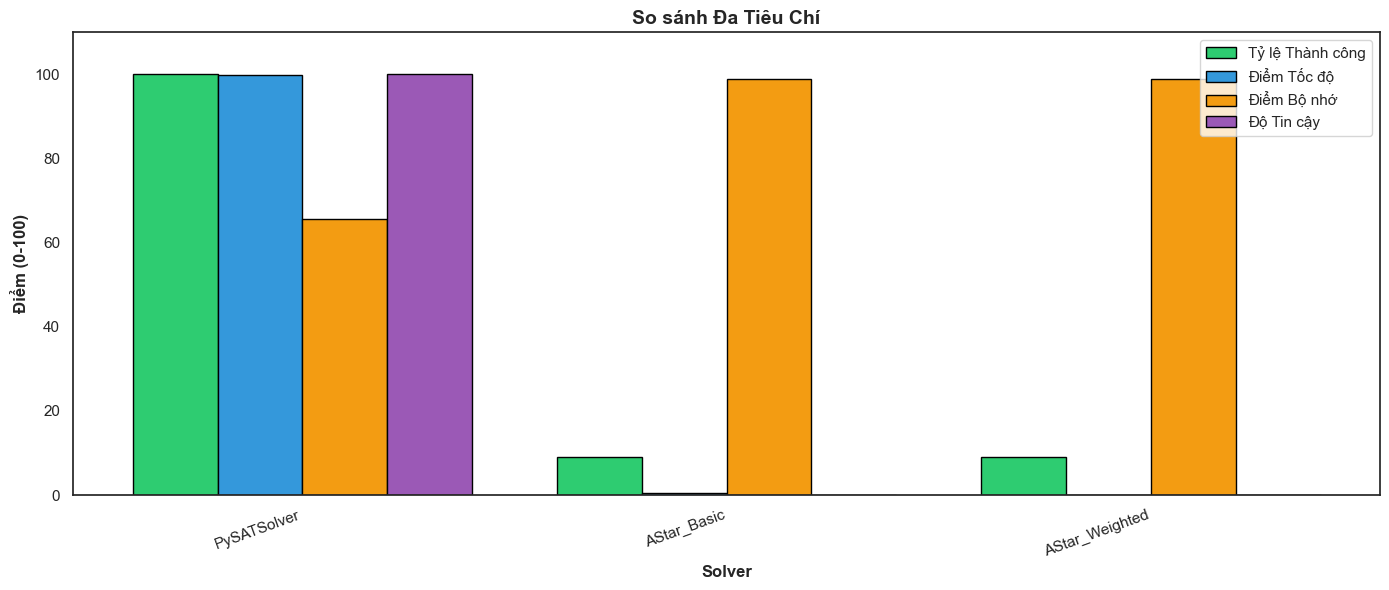

In [16]:
# Biểu đồ đa tiêu chí
x = np.arange(len(final_ranking))
width = 0.2

# Normalize (0-100)
norm = pd.DataFrame({
    'Success': final_ranking['Tỷ_Lệ_%'],
    'Speed': 100 - (final_ranking['TB_Time_s'] / max(final_ranking['TB_Time_s'].max(), 1) * 100),
    'Memory': 100 - (final_ranking['TB_Mem_MB'] / max(final_ranking['TB_Mem_MB'].max(), 1) * 100),
    'Reliability': 100 - (final_ranking['Timeout'] / max(final_ranking['Timeout'].max(), 1) * 100)
})

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5*width, norm['Success'], width, label='Tỷ lệ Thành công', color='#2ecc71', edgecolor='black')
plt.bar(x - 0.5*width, norm['Speed'], width, label='Điểm Tốc độ', color='#3498db', edgecolor='black')
plt.bar(x + 0.5*width, norm['Memory'], width, label='Điểm Bộ nhớ', color='#f39c12', edgecolor='black')
plt.bar(x + 1.5*width, norm['Reliability'], width, label='Độ Tin cậy', color='#9b59b6', edgecolor='black')

plt.xlabel('Solver', fontweight='bold', fontsize=12)
plt.ylabel('Điểm (0-100)', fontweight='bold', fontsize=12)
plt.title('So sánh Đa Tiêu Chí', fontsize=14, fontweight='bold')
plt.xticks(x, final_ranking.index, rotation=20, ha='right')
plt.legend(loc='upper right')
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

---
## 8. Kết Luận

In [17]:
# Kết luận
print("="*70)
print("KẾT LUẬN")
print("="*70)

best_success = final_ranking.index[0]
fastest = df_success.groupby('Solver')['Time (s)'].mean().idxmin()
most_memory_efficient = df_success.groupby('Solver')['Memory (MB)'].mean().idxmin()
most_reliable = final_ranking['Timeout'].idxmin()

print(f"\n🏆 Tỷ lệ Thành công cao nhất: {best_success} ({final_ranking.loc[best_success, 'Tỷ_Lệ_%']}%)")
print(f"⚡ Solver nhanh nhất: {fastest}")
print(f"💾 Tiết kiệm Bộ nhớ nhất: {most_memory_efficient}")
print(f"🎯 Ít Timeout nhất: {most_reliable}")

if best_astar:
    print(f"\n📌 A* Variant được chọn: {best_astar}")

print("\n" + "="*70)
print("KHUYẾN NGHỊ")
print("="*70)
print("• PySATSolver: Sử dụng cho production, đảm bảo độ chính xác")
print("• A* Variants: Nghiên cứu và cải tiến heuristic")
print("• Backtracking: Tối ưu cho bài toán nhỏ")
print("• BruteForce: Chỉ dùng demo, không thực tế")
print("="*70)

KẾT LUẬN

🏆 Tỷ lệ Thành công cao nhất: PySATSolver (100.0%)
⚡ Solver nhanh nhất: PySATSolver
💾 Tiết kiệm Bộ nhớ nhất: AStar_Basic
🎯 Ít Timeout nhất: PySATSolver

📌 A* Variant được chọn: AStar_Basic

KHUYẾN NGHỊ
• PySATSolver: Sử dụng cho production, đảm bảo độ chính xác
• A* Variants: Nghiên cứu và cải tiến heuristic
• Backtracking: Tối ưu cho bài toán nhỏ
• BruteForce: Chỉ dùng demo, không thực tế
